<a href="https://colab.research.google.com/github/shun1y/signate/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 colabへのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 ライブラリの読み込み

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
# ライブラリのimportを行います
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from difflib import get_close_matches
import re

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# ランダムフォレストとAUC評価指標をインポートします。
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 欠損値の補完
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# lightgbm
import lightgbm as lgb

# shap
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 2. データの読み込みと確認


In [ ]:
# 自分のドライブにマウントしているとドライブ上のファイルを読み込むことができます。
# ファイルの場所がわからない場合、左のタブから目的のファイルを探し、「パスをコピー」しペーストすることで読み込めます。
train = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/test.csv")

In [ ]:
train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


In [ ]:
train.shape

(3489, 18)

In [ ]:
test.shape

(3489, 17)

In [ ]:
# value_countsで出現数を確認することができます。
train["ProdTaken"].value_counts()

,count
ProdTaken,
0,2992
1,497


In [ ]:
train.dtypes

,0
id,int64
Age,object
TypeofContact,object
CityTier,int64
DurationOfPitch,object
Occupation,object
Gender,object
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,object


#3.前処理

## データセットの統合

In [ ]:
# トレーニングデータに識別列を追加
train['is_train'] = 1
# テストデータに識別列を追加
test['is_train'] = 0

# トレーニングデータとテストデータを結合
combined_data = pd.concat([train, test], ignore_index=True)

In [ ]:
## 行列数の確認
combined_data.shape

(6978, 19)

## 欠損値の確認

In [ ]:
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,18
CityTier,0
DurationOfPitch,252
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


## EDA

In [ ]:
combined_data.describe()

,id,CityTier,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,is_train
count,6978.000000,6978.000000,6978.000000,6921.000000,6978.000000,6978.000000,6978.000000,3489.000000,6978.000000
mean,3488.500000,1.689882,2.401118,7.306892,3.436515,0.098882,2.507022,0.142448,0.500000
std,2014.519422,0.671595,0.734134,37.262885,0.599600,0.298525,1.134761,0.349559,0.500036
min,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000
25%,1744.250000,1.000000,2.000000,3.000000,3.000000,0.000000,2.000000,0.000000,0.000000
50%,3488.500000,2.000000,2.000000,4.000000,3.000000,0.000000,2.000000,0.000000,0.500000
75%,5232.750000,2.000000,3.000000,4.000000,4.000000,0.000000,3.000000,0.000000,1.000000
max,6977.000000,3.000000,4.000000,600.000000,5.000000,1.000000,5.000000,1.000000,1.000000


In [ ]:
combined_data.shape

(6978, 19)

# 前処理のパイプライン

### Ageの前処理

In [ ]:
# 漢数字を算用数字に変換する辞書
kanji_to_num = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
    '百': 100, '千': 1000
}

# 漢数字を算用数字に変換する関数
def kanji_to_arabic(kanji):
    num = 0
    unit = 1
    for char in reversed(kanji):
        if char in kanji_to_num:
            if kanji_to_num[char] >= 10:
                unit = kanji_to_num[char]
            else:
                num += kanji_to_num[char] * unit
        elif char == '歳':
            continue
    return num

# 全角を半角に変換する関数
def zenkaku_to_hankaku(text):
    return unicodedata.normalize('NFKC', text)

# 'Age'の前処理を行うクラス
class AgePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_age)

    def _preprocess_age(self, age):
        if pd.isna(age):
            return np.nan
        age = str(age)

        # 全角数字を半角数字に変換
        age = zenkaku_to_hankaku(age)

        # 漢数字のxx歳を算用数字のyy歳に変換
        if '歳' in age:
            match = re.search(r'[一二三四五六七八九十百千]+歳', age)
            if match:
                age = str(kanji_to_arabic(match.group(0)))

        # xx代は中央値に寄せる
        if '10代' in age:
            # match = re.search(r'(\d+)代', age)
            # if match:
            age = str(19)

        # xx代は中央値に寄せる
        if '代' in age:
            match = re.search(r'(\d+)代', age)
            if match:
                age = str(int(match.group(1)) + 5)

        # 年齢の数値部分を抜き出す
        match = re.search(r'(\d+)', age)
        if match:
            return int(match.group(1))
        return np.nan


# パイプラインの構築
age_pipeline = Pipeline([('age_preprocessor', AgePreprocessor())])

# 前処理の実行
combined_data['new_Age'] = age_pipeline.fit_transform(combined_data['Age'])

# 'Age' が '十九歳' である行に対して 'new_Age' に 19.0 を代入
combined_data.loc[combined_data['Age'] == '十九歳', 'new_Age'] = 19.0

# 'new_Age' カラムをもとに年代を表すカラムを作成
def determine_age_group(age):
    if pd.isna(age):
        return np.nan
    elif age < 10:
        return '10歳未満'
    else:
        decade = (age // 10) * 10
        return f'{decade}代'

# 新しいカラム 'AgeGroup' を作成
combined_data['AgeGroup'] = combined_data['new_Age'].apply(determine_age_group)

# 新しいカラムを確認
combined_data[['Age', 'new_Age', 'AgeGroup']].value_counts()

,,,count
Age,new_Age,AgeGroup,
30代,35.0,30.0代,224
33歳,33.0,30.0代,194
36歳,36.0,30.0代,188
40代,45.0,40.0代,184
37歳,37.0,30.0代,182
32歳,32.0,30.0代,176
35歳,35.0,30.0代,167
34歳,34.0,30.0代,163
31歳,31.0,30.0代,154


### TypeofContactの前処理

In [ ]:
combined_data['TypeofContact'].fillna('Unknown', inplace=True)
combined_data['TypeofContact'].value_counts()

,count
TypeofContact,
Self Enquiry,4444
Company Invited,2516
Unknown,18


### DurationOfPitchの前処理

In [ ]:
combined_data['DurationOfPitch'].value_counts()

,count
DurationOfPitch,
8分,495
9分,488
15分,432
16分,408
14分,398
10分,366
7分,322
13分,299
11分,233


In [ ]:
class DurationOfPitchPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # ステップ1: xx秒となっているカラムを特定
        seconds_mask = X.str.contains('秒', na=False)

        # ステップ2: 60で割ってyy分に変換
        X.loc[seconds_mask] = X.loc[seconds_mask].str.replace('秒', '').astype(float) / 60

        # ステップ3: 数値部分のみを抜き出す(xx分の分を削除)
        X = X.str.replace('分', '')

        # ステップ4: 欠損値を補完（例: np.nanで補完）
        X = X.astype(float)
        X.fillna(np.nan, inplace=True)

        # ステップ5: 型をfloatからintに変換
        # X = X.astype(int)

        return X

duration_of_pitch_pipeline = Pipeline([
    ('duration_of_pitch_preprocessor', DurationOfPitchPreprocessor())
])

combined_data['DurationOfPitch'] = duration_of_pitch_pipeline.fit_transform(combined_data['DurationOfPitch'])

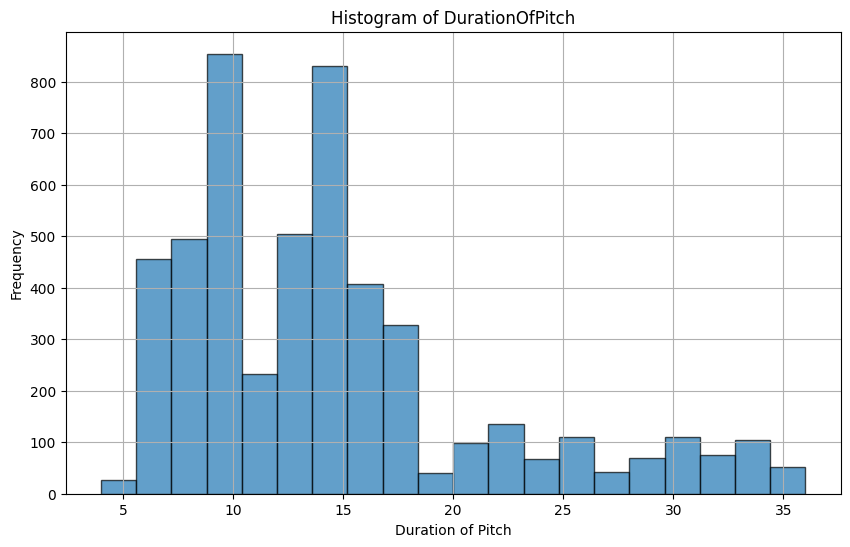

In [ ]:
# 'DurationOfPitch' カラムのヒストグラムを描画
plt.figure(figsize=(10, 6))
plt.hist(combined_data['DurationOfPitch'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of DurationOfPitch')
plt.xlabel('Duration of Pitch')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Occupationの前処理

In [ ]:
combined_data['Occupation'].value_counts()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


### genderの前処理

In [ ]:
combined_data['Gender'].value_counts()

,count
Gender,
Male,2525
Female,1441
male,940
female,504
MALE,363
Ｍａｌｅ,260
Fe Male,213
FEMALE,197
Ｆｅｍａｌｅ,181


In [ ]:
# 性別の標準化を行うクラス
class GenderStandardizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._standardize_gender)

    def _standardize_gender(self, gender):
        gender = zenkaku_to_hankaku(gender)  # 全角を半角に変換
        gender = gender.lower()  # 小文字に変換
        gender = gender.replace(' ', '')  # スペースを削除
        if 'female' in gender:
            return 1
        elif 'male' in gender:
            return 0
        else:
            return np.nan  # 不明な場合

gender_pipeline = Pipeline([
    ('gender_standardizer', GenderStandardizer())
])

combined_data['Gender'] = gender_pipeline.fit_transform(combined_data['Gender'])


# combined_data['Gender'].value_counts()
# combined_data[['Gender', 'new_Gender']].value_counts()

In [ ]:
# combined_data['new_Gender'].value_counts()

### NumberOfPersonVisitingの前処理

In [ ]:
combined_data['NumberOfPersonVisiting'].value_counts()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


### NumberOfFollowupsの前処理

In [ ]:
combined_data['NumberOfFollowups'].value_counts()

,count
NumberOfFollowups,
4.0,2746
3.0,2536
5.0,1113
2.0,212
1.0,176
6.0,69
400.0,31
300.0,25
500.0,9


In [ ]:
# 'NumberOfFollowups'の前処理を行うクラス
class NumberOfFollowupsPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.apply(lambda x: x / 100 if x >= 100 else x)  # 100以上の値を100で割る
        return X.fillna(np.nan)  # 欠損値を0で補完する

number_of_followups_pipeline = Pipeline([
    ('number_of_followups_preprocessor', NumberOfFollowupsPreprocessor())
])

combined_data['NumberOfFollowups'] = number_of_followups_pipeline.fit_transform(combined_data['NumberOfFollowups'])
combined_data['NumberOfFollowups'].value_counts()

,count
NumberOfFollowups,
4.0,2777
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


### ProductPitchedの前処理

In [ ]:
# 'ProductPitched'の前処理と分類を行うクラス
class ProductPitchedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories = ['basic', 'deluxe', 'standard', 'superdeluxe', 'king']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_and_categorize)

    def _preprocess_and_categorize(self, product):
        product = zenkaku_to_hankaku(product)  # 全角を半角に変換
        product = product.lower()  # 大文字を小文字に変換
        product = product.replace(' ', '')  # スペースを削除
        closest_match = get_close_matches(product, self.categories, n=1, cutoff=0.0)
        return closest_match[0] if closest_match else 'unknown'

product_pitched_pipeline = Pipeline([
    ('product_pitched_preprocessor', ProductPitchedPreprocessor())
])

combined_data['ProductPitched'] = product_pitched_pipeline.fit_transform(combined_data['ProductPitched'])


### PreferredPropertyStarの前処理

In [ ]:
combined_data['PreferredPropertyStar'].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


### NumberOfTripsの前処理

In [ ]:
combined_data['NumberOfTrips'].value_counts()

,count
NumberOfTrips,
2,1956
3,1461
5,836
1,669
7,445
年に2回,294
4,277
年に3回,245
6,234


In [ ]:
# 'NumberOfTrips'の前処理を行うクラス
class NumberOfTripsPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_number_of_trips)

    def _preprocess_number_of_trips(self, trips):
        if pd.isnull(trips):
            return np.nan
        trips = str(trips)

        # 年にxx回
        match = re.search(r'年に(\d+)回', trips)
        if match:
            return int(match.group(1))

        # 半年にy回
        match = re.search(r'半年に(\d+)回', trips)
        if match:
            return int(match.group(1)) * 2

        # 四半期にz回
        match = re.search(r'四半期に(\d+)回', trips)
        if match:
            return int(match.group(1)) * 4

        return trips

number_of_trips_pipeline = Pipeline([
    ('number_of_trips_preprocessor', NumberOfTripsPreprocessor())
])

combined_data['NumberOfTrips'] = number_of_trips_pipeline.fit_transform(combined_data['NumberOfTrips'])
# 数値型に変換
combined_data['NumberOfTrips'] = pd.to_numeric(combined_data['NumberOfTrips'], errors='coerce')
# combined_data[['NumberOfTrips', 'new_NumberOfTrips']].value_counts()

In [ ]:
combined_data['NumberOfTrips'].value_counts()

,count
NumberOfTrips,
2.0,2250
3.0,1706
5.0,977
1.0,828
7.0,513
4.0,333
6.0,281
8.0,26


### Passportの前処理

In [ ]:
combined_data['Passport'].value_counts()

,count
Passport,
0,6288
1,690


### PitchSatisfactionScoreの前処理

In [ ]:
combined_data['PitchSatisfactionScore'].value_counts()

,count
PitchSatisfactionScore,
2,2500
4,1452
1,1439
3,1344
5,243


### Designationの前処理

In [ ]:
combined_data['Designation'].value_counts()

,count
Designation,
Executive,2219
Manager,2027
Senior Manager,1565
AVP,604
VP,259
Exеcutive,19
Exеcutivе,19
Μanager,18
Managеr,18


In [ ]:
# 'Designation'の前処理と分類を行うクラス
class DesignationPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories = ['executive', 'manager', 'seniormanager', 'avp', 'vp']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_and_categorize)

    def _preprocess_and_categorize(self, designation):
        designation = zenkaku_to_hankaku(designation)  # 全角を半角に変換
        designation = designation.lower()  # 大文字を小文字に変換
        designation = designation.replace(' ', '')  # スペースを削除
        closest_match = get_close_matches(designation, self.categories, n=1, cutoff=0.0)
        return closest_match[0] if closest_match else 'unknown'

designation_pipeline = Pipeline([
    ('designation_preprocessor', DesignationPreprocessor())
])

combined_data['new_Designation'] = designation_pipeline.fit_transform(combined_data['Designation'])
#'Designation' カラムの文字数を計算し、新しいカラム 'Designation_Length' に追加
combined_data['Designation_Length'] = combined_data['Designation'].apply(len)

# 条件に基づいて 'new_Designation' を 'avp' に置き換え
combined_data.loc[(combined_data['Designation_Length'] >= 3) & (combined_data['new_Designation'] == 'vp'), 'new_Designation'] = 'avp'

combined_data[['Designation', 'new_Designation']].value_counts()

,,count
Designation,new_Designation,
Executive,executive,2219
Manager,manager,2027
Senior Manager,seniormanager,1565
AVP,avp,604
VP,vp,259
Exеcutive,executive,19
Exеcutivе,executive,19
Managеr,manager,18
Μanager,manager,18


### MonthlyIncomeの前処理

In [ ]:
# 'MonthlyIncome'の前処理を行うクラス
class MonthlyIncomePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_monthly_income)

    def _preprocess_monthly_income(self, income):
        if pd.isna(income):
            return np.nan
        income = str(income)

        # xx.x万円の部分を抜き出す
        match = re.search(r'(\d+(\.\d+)?)万円', income)
        if match:
            return int(float(match.group(1)) * 10000)

        # それ以外の値はそのまま使用（適切な処理が必要かもしれません）
        try:
            return int(float(income))
        except ValueError:
            return np.nan

monthly_income_pipeline = Pipeline([
    ('monthly_income_preprocessor', MonthlyIncomePreprocessor())
])

combined_data['MonthlyIncome'] = monthly_income_pipeline.fit_transform(combined_data['MonthlyIncome'])

# combined_data[['MonthlyIncome', 'new_MonthlyIncome']].value_counts()

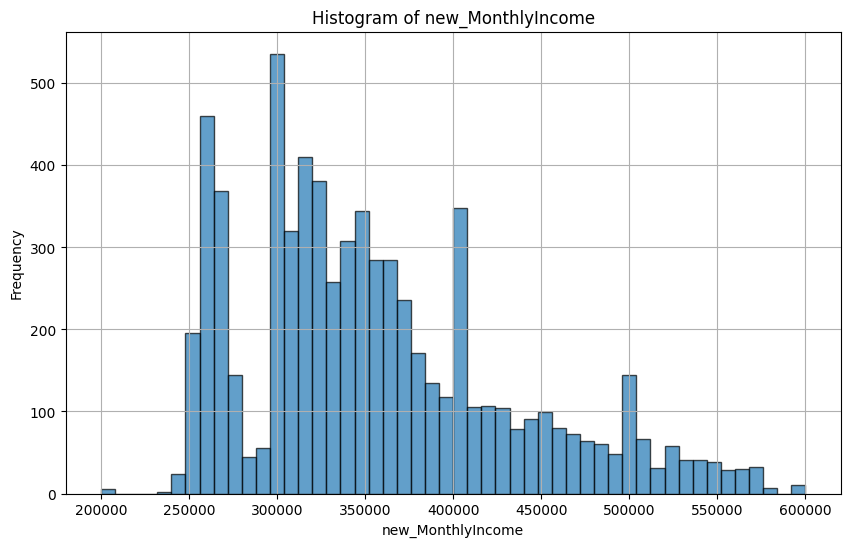

In [ ]:
# 'new_MonthlyIncome' のヒストグラムを細かく描画（ビンの数を増やす）
plt.figure(figsize=(10, 6))
combined_data['MonthlyIncome'].hist(bins=50, edgecolor='k', alpha=0.7)  # binsの値を大きくしてヒストグラムを細かく
plt.title('Histogram of new_MonthlyIncome')
plt.xlabel('new_MonthlyIncome')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### customer_infoの前処理

In [ ]:
# 'customer_info'の分割を行うクラス
class CustomerInfoSplitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._split_customer_info)

    def _split_customer_info(self, text):
        delimiters = '[、, /／\u3000\t\n]'
        split_info = re.split(delimiters, text)
        split_info = (split_info + [None, None, None])[:3]
        return pd.Series(split_info)

# 'customer_info_2'から'has_car'を作成するクラス
class HasCarExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        car_keywords = ['車所持', '自動車所有','車あり','自家用車あり', '乗用車所持', '車保有']
        return X.apply(lambda info: 1 if any(keyword == str(info) for keyword in car_keywords) else 0)

# 'customer_info_3'の前処理を行うクラス
class ChildInfoExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        has_unknown_child_keywords = ['子供の数不明', '不明', '子育て状況不明', '子の数不詳', 'わからない']
        has_child_keywords = ['子供1人', '子供2人', 'こども1人', 'こども2人', '子供有り', '1児', '子供有り(1人)', '子供有り(2人)', '2児', '子供3人', 'こども3人', '3児', '子供有り(3人)']
        has_no_child_keywords = ['子供なし', '子供無し', '子供ゼロ', '無子', '非育児家庭']
        has_one_child_keywords = ['子供1人', 'こども1人', '1児', '子供有り(1人)']
        has_two_child_keywords = ['子供2人', 'こども2人', '子供有り(2人)', '2児']
        has_three_child_keywords = ['子供3人', 'こども3人', '3児', '子供有り(3人)']

        def extract_child_info(info):
            info = str(info)
            if any(keyword in info for keyword in has_unknown_child_keywords):
                return np.nan, np.nan
            elif any(keyword in info for keyword in has_no_child_keywords):
                return 0, 0
            elif any(keyword in info for keyword in has_one_child_keywords):
                return 1, 1
            elif any(keyword in info for keyword in has_two_child_keywords):
                return 2, 1
            elif any(keyword in info for keyword in has_three_child_keywords):
                return 3, 1
            elif any(keyword in info for keyword in has_child_keywords):
                return np.nan, 1
            else:
                return np.nan, np.nan

        # 各データに対してchild_numとhas_childを抽出
        extracted_info = X.apply(extract_child_info)

        # DataFrameに変換
        extracted_df = pd.DataFrame(extracted_info.tolist(), columns=['child_num', 'has_child'])

        return extracted_df

customer_info_pipeline = Pipeline([
    ('customer_info_splitter', CustomerInfoSplitter())
])

car_pipeline = Pipeline([
    ('has_car_extractor', HasCarExtractor())
])

child_pipeline = Pipeline([
    ('child_info_extractor', ChildInfoExtractor())
])

customer_info_split = customer_info_pipeline.fit_transform(combined_data['customer_info'])
combined_data[['customer_info_1', 'customer_info_2', 'customer_info_3']] = customer_info_split

combined_data['has_car'] = car_pipeline.fit_transform(combined_data['customer_info_2'])
# 'has_car' カラムを追加し、条件に基づいて値を代入
# 'has_car' カラムを条件に基づいて更新
combined_data['has_car'] = combined_data['has_car'].mask(combined_data['customer_info_2'] == '車保有なし	', 0)
combined_data['has_car'] = combined_data['has_car'].mask(combined_data['customer_info_2'] == '車あり', 1)


child_info = child_pipeline.fit_transform(combined_data['customer_info_3'])
combined_data['child_num'] = child_info['child_num']
combined_data['has_child'] = child_info['has_child']

# カラム名を変更
combined_data['marry_status'] = combined_data['customer_info_1']

# マッピングを定義
marry_status_mapping = {
    '結婚済み': 'Married',
    '離婚済み': 'Divorced',
    '独身': 'Single',
    '未婚': 'Ummarried'
}

# 'marry_status'の値を英語に変換
combined_data['marry_status'] = combined_data['marry_status'].map(marry_status_mapping)

In [ ]:
# combined_data['customer_info_1'].value_counts()
combined_data['marry_status'].value_counts()
# combined_data['marry_status'].isnull().sum()

combined_data[['marry_status','customer_info_1']].value_counts()

,,count
marry_status,customer_info_1,
Married,結婚済み,2846
Divorced,離婚済み,1688
Single,独身,1309
Ummarried,未婚,1135


In [ ]:
# combined_data['customer_info_1'].value_counts()
combined_data[['has_car','customer_info_2']].value_counts()
# combined_data['marry_status'].isnull().sum()

,,count
has_car,customer_info_2,
0,車未所持,1674
1,車所持,1573
0,自動車未所有,887
1,自動車所有,789
0,自家用車なし,412
1,自家用車あり,405
0,乗用車なし,239
1,乗用車所持,214
0,車なし,205


In [ ]:
combined_data['has_car'].isnull().sum()

0

In [ ]:
# combined_data['customer_info_1'].value_counts()
combined_data[['customer_info_3', 'has_child', 'child_num']].value_counts(dropna=False)
# combined_data['marry_status'].isnull().sum()

,,,count
customer_info_3,has_child,child_num,
子供1人,1.0,1.0,1699
子供なし,0.0,0.0,1038
子供2人,1.0,2.0,921
こども1人,1.0,1.0,832
子供無し,0.0,0.0,507
こども2人,1.0,2.0,456
子供有り,1.0,NaN,321
1児,1.0,1.0,220
子供有り(1人),1.0,1.0,194


# 前処理後のデータの確認

In [ ]:
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,0
CityTier,0
DurationOfPitch,1939
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


In [ ]:
# new_DesignationをDesignationに代入
combined_data['Designation'] = combined_data['new_Designation']
combined_data['Age'] = combined_data['new_Age']

# 指定されたカラムを削除
combined_data = combined_data.drop(columns=['customer_info', 'customer_info_1', 'customer_info_2', 'customer_info_3', 'new_Designation', 'Designation_Length','new_Age'])

# 結果を確認
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,0
CityTier,0
DurationOfPitch,1939
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


In [ ]:
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,0
CityTier,0
DurationOfPitch,1939
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


In [ ]:
combined_data.dtypes

,0
id,int64
Age,float64
TypeofContact,object
CityTier,int64
DurationOfPitch,float64
Occupation,object
Gender,int64
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,object


In [ ]:
combined_data[['AgeGroup','Age']].value_counts()

AgeGroup  Age 
30.0代     35.0    469
40.0代     45.0    354
30.0代     33.0    263
          36.0    257
50.0代     55.0    252
30.0代     37.0    238
          32.0    234
          34.0    234
          31.0    217
          38.0    206
          39.0    204
40.0代     42.0    198
30.0代     30.0    194
20.0代     25.0    193
40.0代     40.0    188
          41.0    186
          43.0    170
50.0代     50.0    165
20.0代     28.0    160
          29.0    158
50.0代     51.0    156
          52.0    154
40.0代     46.0    146
          47.0    144
          49.0    136
50.0代     53.0    131
          54.0    131
40.0代     44.0    129
          48.0    125
20.0代     26.0    123
          27.0    122
50.0代     56.0     97
20.0代     24.0     96
50.0代     57.0     86
20.0代     22.0     81
          23.0     74
50.0代     58.0     63
20.0代     21.0     58
50.0代     59.0     53
20.0代     20.0     47
60.0代     60.0     30
10.0代     19.0     28
          18.0     17
60.0代     61.0     14
          65.0      4
Name: count, dtype: int64

# 前処理後のデータをdriveに保存

In [ ]:
# ディレクトリを指定して保存
file_path = '/content/drive/MyDrive/SIGNATE_Cup 2024/data/combined_data.csv'
combined_data.to_csv(file_path, index=False)

print(f'File saved to {file_path}')

File saved to /content/drive/MyDrive/SIGNATE_Cup 2024/data/combined_data.csv


In [ ]:
# 漢数字を算用数字に変換する辞書
kanji_to_num = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
    '百': 100, '千': 1000
}

# 漢数字を算用数字に変換する関数
def kanji_to_arabic(kanji):
    num = 0
    unit = 1
    for char in reversed(kanji):
        if char in kanji_to_num:
            if kanji_to_num[char] >= 10:
                unit = kanji_to_num[char]
            else:
                num += kanji_to_num[char] * unit
        elif char == '歳':
            continue
    return num

# 全角を半角に変換する関数
def zenkaku_to_hankaku(text):
    return unicodedata.normalize('NFKC', text)

# 'Age'の前処理を行うクラス
class AgePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_age)

    def _preprocess_age(self, age):
        if pd.isna(age):
            return np.nan
        age = str(age)

        # 全角数字を半角数字に変換
        age = zenkaku_to_hankaku(age)

        # 漢数字のxx歳を算用数字のyy歳に変換
        if '歳' in age:
            match = re.search(r'[一二三四五六七八九十百千]+歳', age)
            if match:
                age = str(kanji_to_arabic(match.group(0)))

        # xx代は中央値に寄せる
        if '代' in age:
            match = re.search(r'(\d+)代', age)
            if match:
                age = str(int(match.group(1)) + 5)

        # 年齢の数値部分を抜き出す
        match = re.search(r'(\d+)', age)
        if match:
            return int(match.group(1))
        return np.nan

# 'TypeofContact'の欠損値を'Unknown'で補完するクラス
class TypeofContactImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.fillna('Unknown')


class DurationOfPitchPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # ステップ1: xx秒となっているカラムを特定
        seconds_mask = X.str.contains('秒', na=False)

        # ステップ2: 60で割ってyy分に変換
        X.loc[seconds_mask] = X.loc[seconds_mask].str.replace('秒', '').astype(float) / 60

        # ステップ3: 数値部分のみを抜き出す(xx分の分を削除)
        X = X.str.replace('分', '')

        # ステップ4: 欠損値を補完（例: np.nanで補完）
        X = X.astype(float)
        X.fillna(np.nan, inplace=True)

        # ステップ5: 型をfloatからintに変換
        # X = X.astype(int)

        return X

# 性別の標準化を行うクラス
class GenderStandardizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._standardize_gender)

    def _standardize_gender(self, gender):
        gender = zenkaku_to_hankaku(gender)  # 全角を半角に変換
        gender = gender.lower()  # 小文字に変換
        gender = gender.replace(' ', '')  # スペースを削除
        if 'female' in gender:
            return 1
        elif 'male' in gender:
            return 0
        else:
            return np.nan  # 不明な場合

# 'NumberOfFollowups'の前処理を行うクラス
class NumberOfFollowupsPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.apply(lambda x: x / 100 if x >= 100 else x)  # 100以上の値を100で割る
        return X.fillna(np.nan)  # 欠損値を0で補完する

# 'ProductPitched'の前処理と分類を行うクラス
class ProductPitchedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories = ['basic', 'deluxe', 'standard', 'superdeluxe', 'king']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_and_categorize)

    def _preprocess_and_categorize(self, product):
        product = zenkaku_to_hankaku(product)  # 全角を半角に変換
        product = product.lower()  # 大文字を小文字に変換
        product = product.replace(' ', '')  # スペースを削除
        closest_match = get_close_matches(product, self.categories, n=1, cutoff=0.0)
        return closest_match[0] if closest_match else 'unknown'

# 'NumberOfTrips'の前処理を行うクラス
class NumberOfTripsPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_number_of_trips)

    def _preprocess_number_of_trips(self, trips):
        if pd.isna(trips):
            return np.na
        trips = str(trips)

        # 年にxx回
        match = re.search(r'年に(\d+)回', trips)
        if match:
            return int(match.group(1))

        # 半年にy回
        match = re.search(r'半年に(\d+)回', trips)
        if match:
            return int(match.group(1)) * 2

        # 四半期にz回
        match = re.search(r'四半期に(\d+)回', trips)
        if match:
            return int(match.group(1)) * 4

        return trips

# 'Designation'の前処理と分類を行うクラス
class DesignationPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories = ['executive', 'manager', 'seniormanager', 'avp', 'vp']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_and_categorize)

    def _preprocess_and_categorize(self, designation):
        designation = zenkaku_to_hankaku(designation)  # 全角を半角に変換
        designation = designation.lower()  # 大文字を小文字に変換
        designation = designation.replace(' ', '')  # スペースを削除
        closest_match = get_close_matches(designation, self.categories, n=1, cutoff=0.0)
        return closest_match[0] if closest_match else 'unknown'

# 'MonthlyIncome'の前処理を行うクラス
class MonthlyIncomePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_monthly_income)

    def _preprocess_monthly_income(self, income):
        if pd.isna(income):
            return np.nan
        income = str(income)

        # xx.x万円の部分を抜き出す
        match = re.search(r'(\d+(\.\d+)?)万円', income)
        if match:
            return int(float(match.group(1)) * 10000)

        # それ以外の値はそのまま使用（適切な処理が必要かもしれません）
        try:
            return int(float(income))
        except ValueError:
            return np.nan

# 'customer_info'の分割を行うクラス
class CustomerInfoSplitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._split_customer_info)

    def _split_customer_info(self, text):
        delimiters = '[、, /／\u3000\t\n]'
        split_info = re.split(delimiters, text)
        split_info = (split_info + [None, None, None])[:3]
        return pd.Series(split_info)

# 'customer_info_2'から'has_car'を作成するクラス
class HasCarExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        car_keywords = ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり']
        return X.apply(lambda info: 1 if any(keyword in str(info) for keyword in car_keywords) else 0)

# 'customer_info_3'の前処理を行うクラス
class ChildInfoExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        has_unknown_child_keywords = ['子供の数不明', '不明', '子育て状況不明', '子の数不詳', 'わからない']
        has_child_keywords = ['子供1人', '子供2人', 'こども1人', 'こども2人', '子供有り', '1児', '子供有り(1人)', '子供有り(2人)', '2児', '子供3人', 'こども3人', '3児', '子供有り(3人)']
        has_no_child_keywords = ['子供なし', '子供無し', '子供ゼロ', '無子', '非育児家庭']
        has_one_child_keywords = ['子供1人', 'こども1人', '1児', '子供有り(1人)']
        has_two_child_keywords = ['子供2人', 'こども2人', '子供有り(2人)', '2児']
        has_three_child_keywords = ['子供3人', 'こども3人', '3児', '子供有り(3人)']

        def extract_child_info(info):
            info = str(info)
            if any(keyword in info for keyword in has_unknown_child_keywords):
                return np.nan, np.nan
            elif any(keyword in info for keyword in has_no_child_keywords):
                return 0, 0
            elif any(keyword in info for keyword in has_one_child_keywords):
                return 1, 1
            elif any(keyword in info for keyword in has_two_child_keywords):
                return 2, 1
            elif any(keyword in info for keyword in has_three_child_keywords):
                return 3, 1
            elif any(keyword in info for keyword in has_child_keywords):
                return np.nan, 1
            else:
                return np.nan, np.nan

        # 各データに対してchild_numとhas_childを抽出
        extracted_info = X.apply(extract_child_info)

        # DataFrameに変換
        extracted_df = pd.DataFrame(extracted_info.tolist(), columns=['child_num', 'has_child'])

        return extracted_df

# パイプラインの構築
age_pipeline = Pipeline([
    ('age_preprocessor', AgePreprocessor())
])
typeof_contact_pipeline = Pipeline([
    ('typeof_contact_imputer', TypeofContactImputer())
])

duration_of_pitch_pipeline = Pipeline([
    ('duration_of_pitch_preprocessor', DurationOfPitchPreprocessor())
])

gender_pipeline = Pipeline([
    ('gender_standardizer', GenderStandardizer())
])

number_of_followups_pipeline = Pipeline([
    ('number_of_followups_preprocessor', NumberOfFollowupsPreprocessor())
])

product_pitched_pipeline = Pipeline([
    ('product_pitched_preprocessor', ProductPitchedPreprocessor())
])

number_of_trips_pipeline = Pipeline([
    ('number_of_trips_preprocessor', NumberOfTripsPreprocessor())
])

designation_pipeline = Pipeline([
    ('designation_preprocessor', DesignationPreprocessor())
])

monthly_income_pipeline = Pipeline([
    ('monthly_income_preprocessor', MonthlyIncomePreprocessor())
])

customer_info_pipeline = Pipeline([
    ('customer_info_splitter', CustomerInfoSplitter())
])

car_pipeline = Pipeline([
    ('has_car_extractor', HasCarExtractor())
])

child_pipeline = Pipeline([
    ('child_info_extractor', ChildInfoExtractor())
])

# 前処理の実行
combined_data['Age'] = age_pipeline.fit_transform(combined_data['Age'])
combined_data['TypeofContact'] = typeof_contact_pipeline.fit_transform(combined_data['TypeofContact'])
combined_data['DurationOfPitch'] = duration_of_pitch_pipeline.fit_transform(combined_data['DurationOfPitch'])
combined_data['Gender'] = gender_pipeline.fit_transform(combined_data['Gender'])
combined_data['NumberOfFollowups'] = number_of_followups_pipeline.fit_transform(combined_data['NumberOfFollowups'])
combined_data['ProductPitched'] = product_pitched_pipeline.fit_transform(combined_data['ProductPitched'])
combined_data['new_NumberOfTrips'] = number_of_trips_pipeline.fit_transform(combined_data['NumberOfTrips'])
combined_data['Designation'] = designation_pipeline.fit_transform(combined_data['Designation'])
combined_data['MonthlyIncome'] = monthly_income_pipeline.fit_transform(combined_data['MonthlyIncome'])

customer_info_split = customer_info_pipeline.fit_transform(combined_data['customer_info'])
combined_data[['customer_info_1', 'customer_info_2', 'customer_info_3']] = customer_info_split

combined_data['has_car'] = car_pipeline.fit_transform(combined_data['customer_info_2'])
child_info = child_pipeline.fit_transform(combined_data['customer_info_3'])
combined_data['child_num'] = child_info['child_num']
combined_data['has_child'] = child_info['has_child']

# カラム名を変更
combined_data['marry_status'] = combined_data['customer_info_1']

# マッピングを定義
marry_status_mapping = {
    '結婚済み': 'Married',
    '離婚済み': 'Divorced',
    '独身': 'Single',
    '未婚': 'Ummarried'
}

# 'marry_status'の値を英語に変換
combined_data['marry_status'] = combined_data['marry_status'].map(marry_status_mapping)

# # 役職が高い順にマッピング
# designation_mapping = {
#     'executive': 1,
#     'vp': 2,
#     'avp': 3,
#     'seniormanager': 4,
#     'manager': 5
# }

# # 'Designation'の値を数値に変換
# combined_data['Designation'] = combined_data['Designation'].map(designation_mapping)

# 製品のランクをマッピング
product_pitched_mapping = {
    'king': 1,
    'superdeluxe': 2,
    'deluxe': 3,
    'standard': 4,
    'basic': 5
}

# 'ProductPitched'の値を数値に変換
combined_data['ProductPitched'] = combined_data['ProductPitched'].map(product_pitched_mapping)

# 不要なカラムを削除
combined_data.drop(columns=['customer_info', 'customer_info_1', 'customer_info_2','customer_info_3'], inplace=True)


AttributeError: Can only use .str accessor with string values!

In [ ]:
combined_data.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,is_train,has_car,child_num,has_child,marry_status
0,0,50.0,Self Enquiry,2,NaN,Large Business,0,1.0,4.0,5,...,1,4,executive,253905.0,1.0,1,0,0.0,0.0,Ummarried
1,1,56.0,Company Invited,1,14.0,Salaried,0,1.0,4.0,4,...,1,4,seniormanager,404475.0,0.0,1,1,0.0,0.0,Divorced
2,2,NaN,Self Enquiry,1,10.0,Large Business,1,1.0,3.0,5,...,0,4,executive,278145.0,1.0,1,0,0.0,0.0,Married
3,3,37.0,Self Enquiry,2,NaN,Small Business,1,1.0,3.0,4,...,0,5,seniormanager,326805.0,0.0,1,1,0.0,0.0,Divorced
4,4,48.0,Company Invited,3,NaN,Small Business,1,1.0,3.0,5,...,0,4,executive,258435.0,1.0,1,1,0.0,0.0,Single


In [ ]:
combined_data.dtypes

,0
id,int64
Age,float64
TypeofContact,object
CityTier,int64
DurationOfPitch,float64
Occupation,object
Gender,int64
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,int64


In [ ]:
combined_data.isnull().sum()

,0
id,0
Age,193
TypeofContact,0
CityTier,0
DurationOfPitch,1939
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,57
ProductPitched,0


In [ ]:
combined_data['NumberOfTrips'].value_counts()

,count
NumberOfTrips,
2,1956
3,1461
5,836
1,669
7,445
2,294
4,277
3,245
6,234


In [ ]:

# 半角に統一する関数
def convert_to_halfwidth(text):
    if pd.isna(text):  # 欠損値の場合はそのまま返す
        return text
    return unicodedata.normalize('NFKC', str(text))

# 'NumberOfTrips' カラムを半角に統一
combined_data['NumberOfTrips'] = combined_data['NumberOfTrips'].apply(convert_to_halfwidth)

# 数値型に変換
combined_data['NumberOfTrips'] = pd.to_numeric(combined_data['NumberOfTrips'], errors='coerce')

# 結果を確認
print(combined_data['NumberOfTrips'].unique())



[ 5.  2.  4.  1.  6.  3.  7.  8. nan]


,count
NumberOfTrips,
2.0,2250
3.0,1706
5.0,977
1.0,828
7.0,513
4.0,333
6.0,281
8.0,26


In [ ]:
combined_data.describe()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,is_train,has_car,child_num,has_child
count,6978.000000,6785.000000,6978.000000,5039.000000,6978.000000,6978.000000,6921.000000,6978.000000,6978.000000,6914.000000,6978.000000,6978.000000,6873.000000,3489.000000,6978.000000,6978.000000,6583.000000,6904.000000
mean,3488.500000,39.307296,1.689882,14.450685,0.395529,2.401118,3.673602,3.730295,3.436515,3.203356,0.098882,2.507022,356131.710316,0.142448,0.500000,0.510318,0.992253,0.723494
std,2014.519422,9.940435,0.671595,6.983555,0.488999,0.734134,0.905959,1.139818,0.599600,1.738931,0.298525,1.134761,76149.009367,0.349559,0.500036,0.499929,0.781957,0.447303
min,0.000000,9.000000,1.000000,4.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,200000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1744.250000,32.000000,1.000000,9.000000,0.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,2.000000,300000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3488.500000,38.000000,2.000000,13.000000,0.000000,2.000000,4.000000,4.000000,3.000000,3.000000,0.000000,2.000000,342075.000000,0.000000,0.500000,1.000000,1.000000,1.000000
75%,5232.750000,47.000000,2.000000,16.000000,1.000000,3.000000,4.000000,5.000000,4.000000,5.000000,0.000000,3.000000,400000.000000,0.000000,1.000000,1.000000,2.000000,1.000000
max,6977.000000,65.000000,3.000000,36.000000,1.000000,4.000000,6.000000,5.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,1.000000,1.000000,1.000000,3.000000,1.000000


# 各カラムの値の出現回数の可視化


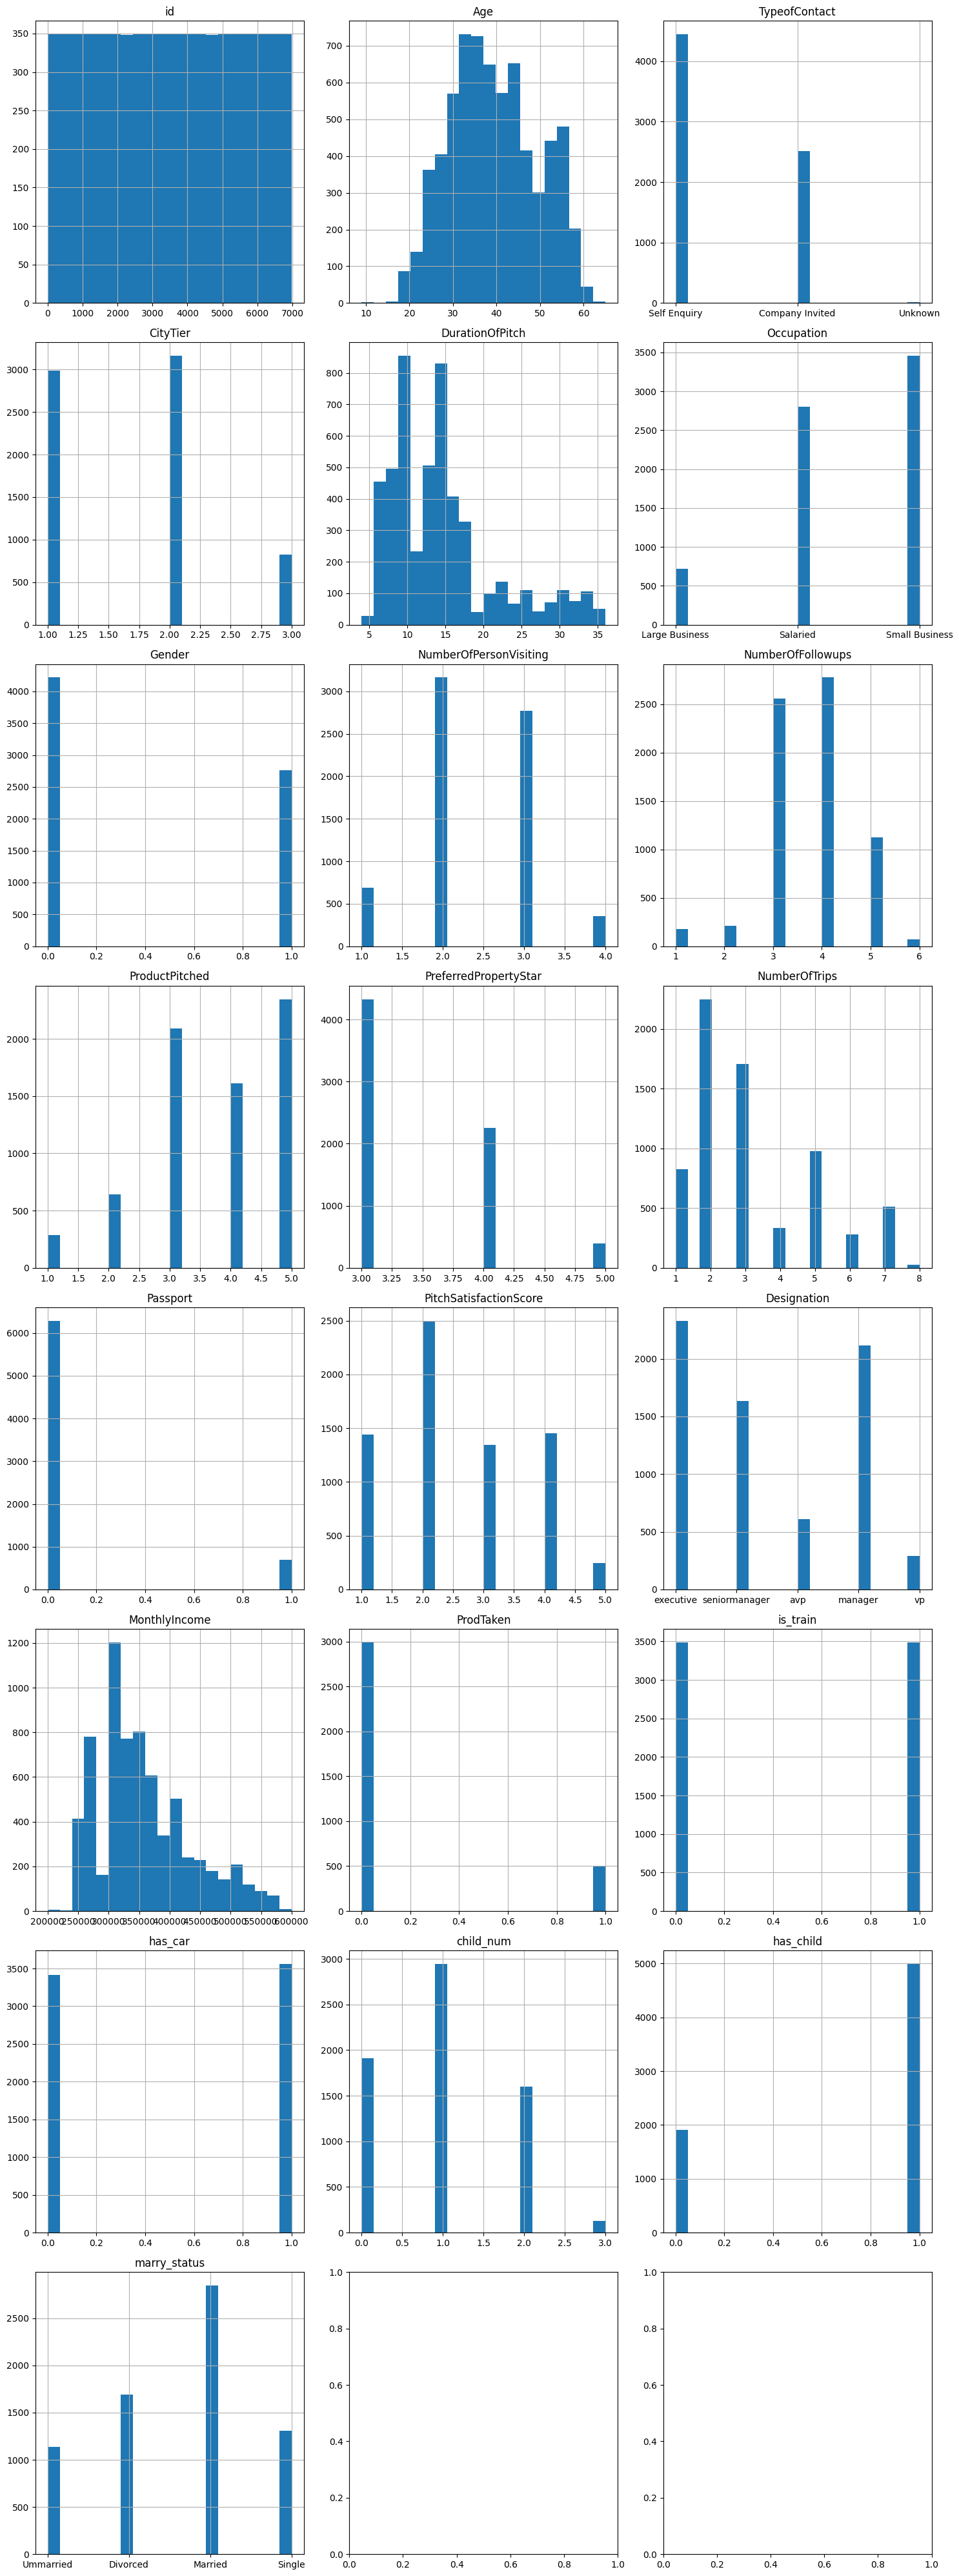

In [ ]:
# 各カラムのヒストグラムを描画
def plot_histograms(df):
    num_columns = len(df.columns)
    num_rows = (num_columns + 2) // 3  # 1行あたり3つのカラムを表示する
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i, column in enumerate(df.columns):
        ax = axes[i // 3, i % 3]
        df[column].dropna().hist(ax=ax, bins=20)
        ax.set_title(column)

    plt.tight_layout()
    plt.show()

# ヒストグラムの描画を実行
plot_histograms(combined_data)

In [ ]:
# オブジェクト型のカラムを抽出
object_columns = combined_data.select_dtypes(include=['object']).columns

# One-hotエンコーディングを実行
combined_data_encoded = pd.get_dummies(combined_data, columns=object_columns)

combined_data_encoded.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,...,Occupation_Small Business,Designation_avp,Designation_executive,Designation_manager,Designation_seniormanager,Designation_vp,marry_status_Divorced,marry_status_Married,marry_status_Single,marry_status_Ummarried
0,0,50.0,2,NaN,0,1.0,4.0,5,3.0,5.0,...,False,False,True,False,False,False,False,False,False,True
1,1,56.0,1,14.0,0,1.0,4.0,4,3.0,2.0,...,False,False,False,False,True,False,True,False,False,False
2,2,NaN,1,10.0,1,1.0,3.0,5,3.0,4.0,...,False,False,True,False,False,False,False,True,False,False
3,3,37.0,2,NaN,1,1.0,3.0,4,4.0,1.0,...,True,False,False,False,True,False,True,False,False,False
4,4,48.0,3,NaN,1,1.0,3.0,5,4.0,4.0,...,True,False,True,False,False,False,False,False,True,False


In [ ]:
combined_data_encoded.dtypes

,0
id,int64
Age,float64
CityTier,int64
DurationOfPitch,float64
Gender,int64
NumberOfPersonVisiting,float64
NumberOfFollowups,float64
ProductPitched,int64
PreferredPropertyStar,float64
NumberOfTrips,float64


## AgeとMonthlyIncomeとDurationOfPitchの欠損値を補完する


In [ ]:
# # 'Age' と 'MonthlyIncome' が -1 のものを NaN に置換
# combined_data_encoded['Age'] = combined_data_encoded['Age'].replace(-1, np.nan)
# # combined_data_encoded['MonthlyIncome'] = combined_data_encoded['MonthlyIncome'].replace(-1, np.nan)

# # 確認のための出力
# # print(combined_data_encoded.isnull().sum())

In [ ]:
# 欠損値のある列を特定（例: 'target_column'に欠損値があると仮定）
target_column = 'Age'

# 'ProdTaken'カラムを除外して特徴量を選択
X = combined_data_encoded.drop(columns=[target_column, 'ProdTaken','id','is_train'])
y = combined_data_encoded[target_column]

# 欠損値のないデータを使ってランダムフォレストモデルを訓練
X_train = X[~y.isna()]
y_train = y[~y.isna()]

# 欠損値があるデータを特定
X_missing = X[y.isna()]

# ランダムフォレストモデルの定義と訓練
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 欠損値の予測
y_pred = rf.predict(X_missing)

# 欠損値の補完
combined_data_encoded.loc[y.isna(), target_column] = y_pred

# 補完後のデータを表示
# print(combined_data_encoded.isnull().sum())

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# 'Age' と 'MonthlyIncome' が -1 のものを NaN に置換
# combined_data_encoded['Age'] = combined_data_encoded['Age'].replace(-1, np.nan)
combined_data_encoded['MonthlyIncome'] = combined_data_encoded['MonthlyIncome'].replace(-1, np.nan)

# 確認のための出力
# print(combined_data_encoded.isnull().sum())

In [ ]:
# 欠損値のある列を特定（例: 'target_column'に欠損値があると仮定）
target_column = 'MonthlyIncome'

# 'ProdTaken'カラムを除外して特徴量を選択
X = combined_data_encoded.drop(columns=[target_column, 'ProdTaken','id','is_train'])
y = combined_data_encoded[target_column]

# 欠損値のないデータを使ってランダムフォレストモデルを訓練
X_train = X[~y.isna()]
y_train = y[~y.isna()]

# 欠損値があるデータを特定
X_missing = X[y.isna()]

# ランダムフォレストモデルの定義と訓練
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 欠損値の予測
y_pred = rf.predict(X_missing)

# 欠損値の補完
combined_data_encoded.loc[y.isna(), target_column] = y_pred

# 補完後のデータを表示
# print(combined_data_encoded.isnull().sum())

In [ ]:
combined_data_encoded['DurationOfPitch'] = combined_data_encoded['DurationOfPitch'].replace(-1, np.nan)

# 確認のための出力
# print(combined_data_encoded.isnull().sum())

In [ ]:
# 欠損値のある列を特定（例: 'target_column'に欠損値があると仮定）
target_column = 'DurationOfPitch'

# 'ProdTaken'カラムを除外して特徴量を選択
X = combined_data_encoded.drop(columns=[target_column, 'ProdTaken','id','is_train'])
y = combined_data_encoded[target_column]

# 欠損値のないデータを使ってランダムフォレストモデルを訓練
X_train = X[~y.isna()]
y_train = y[~y.isna()]

# 欠損値があるデータを特定
X_missing = X[y.isna()]

# ランダムフォレストモデルの定義と訓練
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 欠損値の予測
y_pred = rf.predict(X_missing)

# 欠損値の補完
combined_data_encoded.loc[y.isna(), target_column] = y_pred

# 補完後のデータを表示
# print(combined_data_encoded.isnull().sum())

In [ ]:
combined_data_encoded = combined_data_encoded.astype(float)

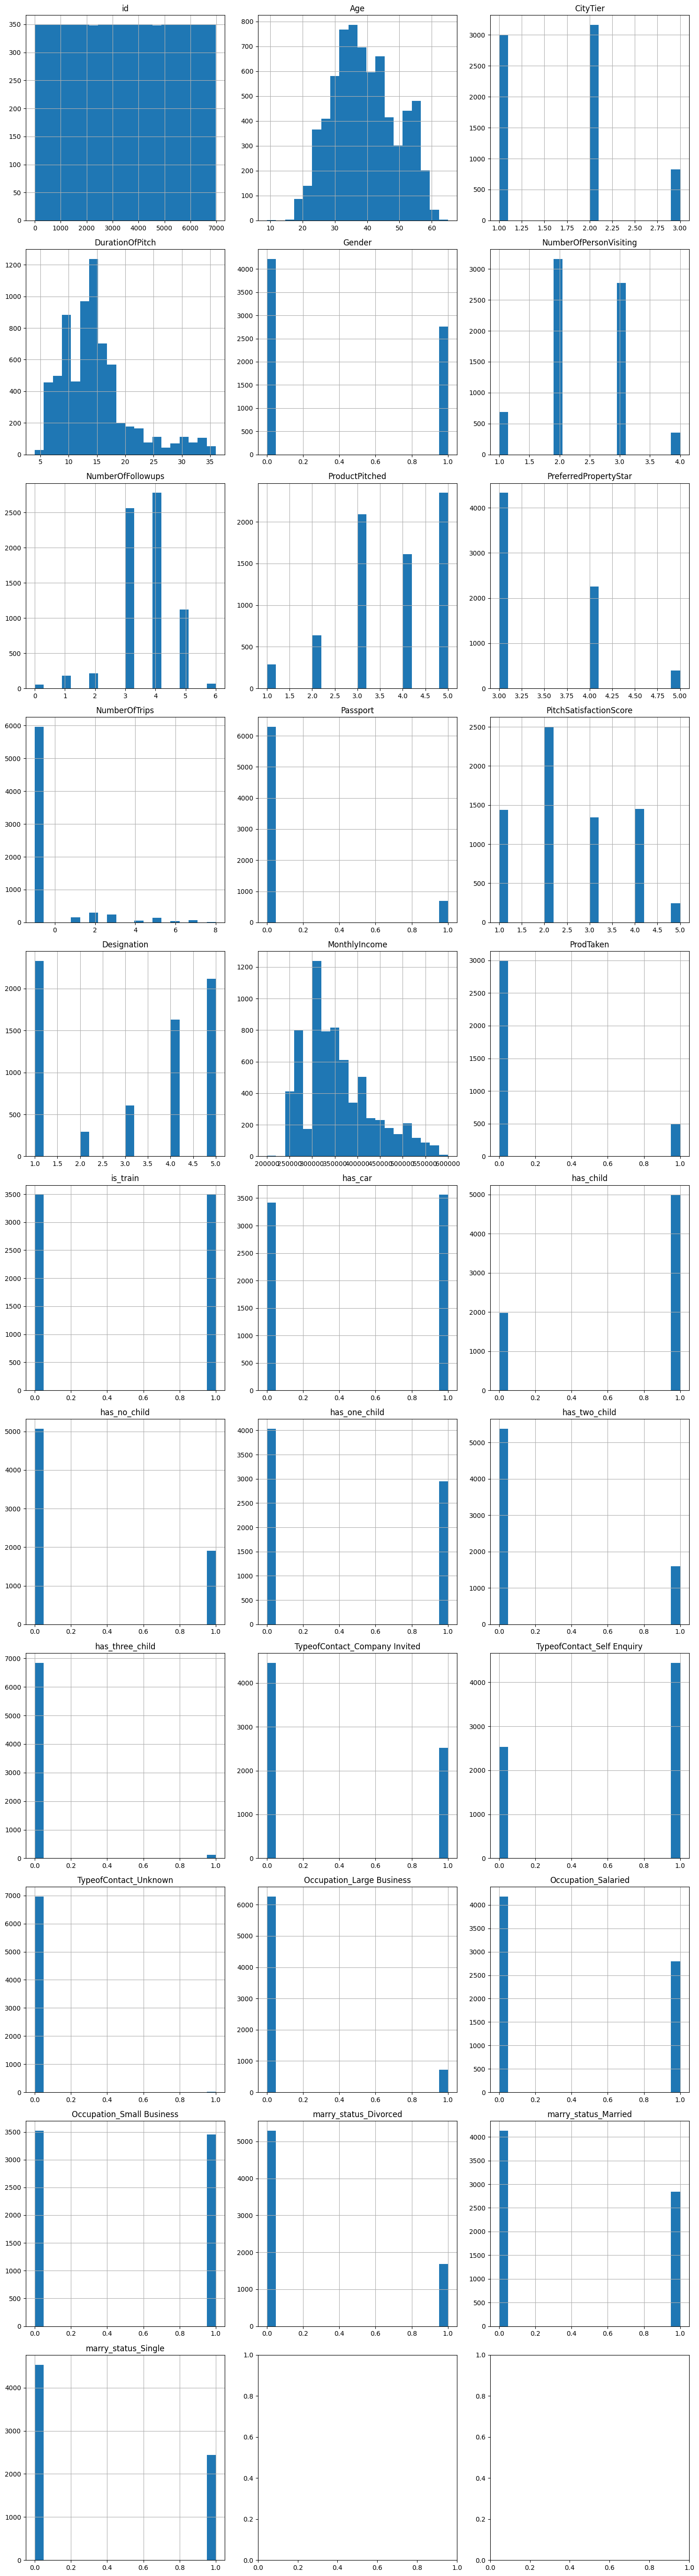

In [ ]:
# 各カラムのヒストグラムを描画
def plot_histograms(df):
    num_columns = len(df.columns)
    num_rows = (num_columns + 2) // 3  # 1行あたり3つのカラムを表示する
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i, column in enumerate(df.columns):
        ax = axes[i // 3, i % 3]
        df[column].dropna().hist(ax=ax, bins=20)
        ax.set_title(column)

    plt.tight_layout()
    plt.show()

# ヒストグラムの描画を実行
plot_histograms(combined_data_encoded)

# 4.3 データセットを訓練データセットとテストデータセットに分割する

In [ ]:
# combined_data_encodedをtrainとtestのでーたセットに戻す

train = combined_data_encoded[combined_data_encoded['is_train'] == 1]
test = combined_data_encoded[combined_data_encoded['is_train'] == 0]

# "ProdTaken"は予測対象とするため、別途target変数に格納する
target = train["ProdTaken"]

train.drop(['is_train','ProdTaken','id'], axis=1, inplace=True)
test.drop(['is_train','ProdTaken','id'], axis=1, inplace=True)

<ipython-input-51-81a586c3fdf5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['is_train','ProdTaken','id'], axis=1, inplace=True)
<ipython-input-51-81a586c3fdf5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['is_train','ProdTaken','id'], axis=1, inplace=True)


In [ ]:
train.shape

(3489, 28)

In [ ]:
test.shape

(3489, 28)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
        train, target, test_size=0.3, random_state=42, stratify=target
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(2442, 28) (1047, 28) (2442,) (1047,)


## 5. 学習と検証

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 278, number of negative: 1675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1953, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142345 -> initscore=-1.795947
[LightGBM] [Info] Start training from score -1.795947
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 278, number of negative: 1675
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number

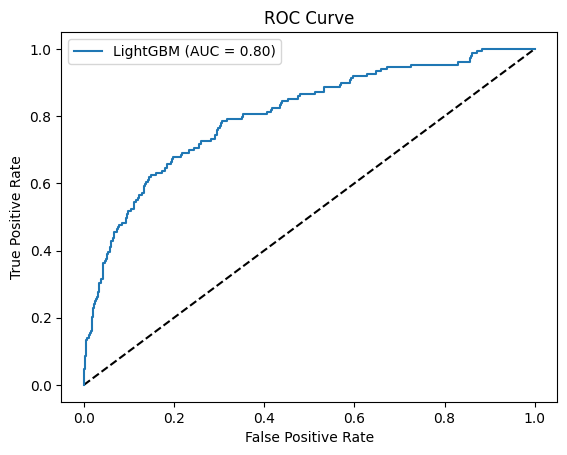

In [ ]:
# LightGBMのインスタンスを作成
lgb_model = lgb.LGBMClassifier(random_state=42)

# StratifiedKFoldの設定 (stratify=targetの要素を持たせる)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 交差検証の実行
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring='roc_auc')

# 交差検証結果の表示
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores)}")

# 交差検証後、全データでモデルを再トレーニング
lgb_model.fit(X_train, y_train)

# y_validに対する予測確率を計算
# pred_proba[:, 1] は陽性クラス（1）に対する確率
pred_proba = lgb_model.predict_proba(X_valid)

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_valid, pred_proba[:, 1])

# ROC AUCスコアの計算
roc_auc = roc_auc_score(y_valid, pred_proba[:, 1])
print(f"ROC AUC: {roc_auc}")

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')  # 斜めの基準線
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

MonthlyIncome: 668
Age: 475
DurationOfPitch: 459
PitchSatisfactionScore: 163
NumberOfPersonVisiting: 107
NumberOfFollowups: 98
CityTier: 94
Gender: 91
Designation: 89
NumberOfTrips: 76
PreferredPropertyStar: 67
Passport: 66
has_car: 65
Occupation_Salaried: 54
ProductPitched: 53
TypeofContact_Company Invited: 52
marry_status_Married: 50
marry_status_Single: 49
has_one_child: 41
Occupation_Small Business: 37
marry_status_Divorced: 35
has_two_child: 28
Occupation_Large Business: 26
has_child: 19
has_no_child: 19
TypeofContact_Self Enquiry: 19
has_three_child: 0
TypeofContact_Unknown: 0


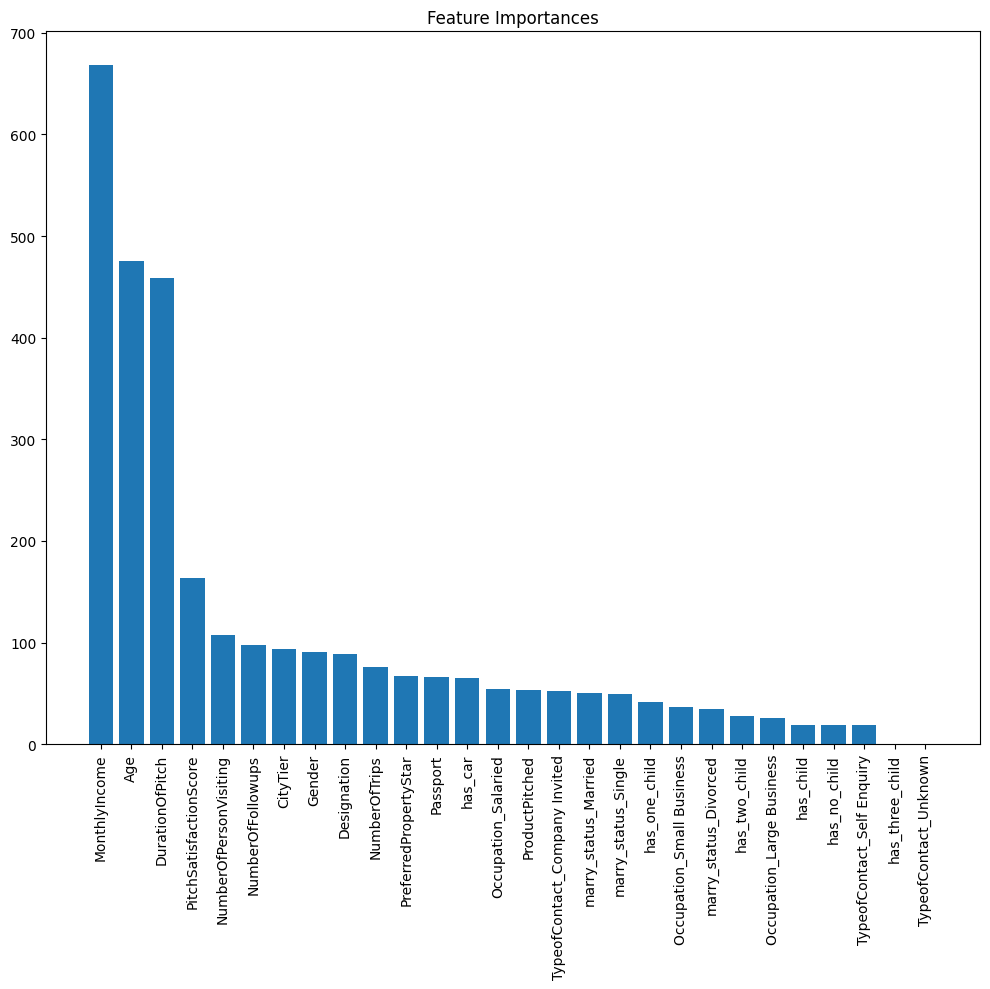

In [ ]:
# 特徴量の重要度を抽出する
importances = lgb_model.feature_importances_

# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 重要度の降順で特徴量の名称、重要度を表示
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")

# 表示する
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


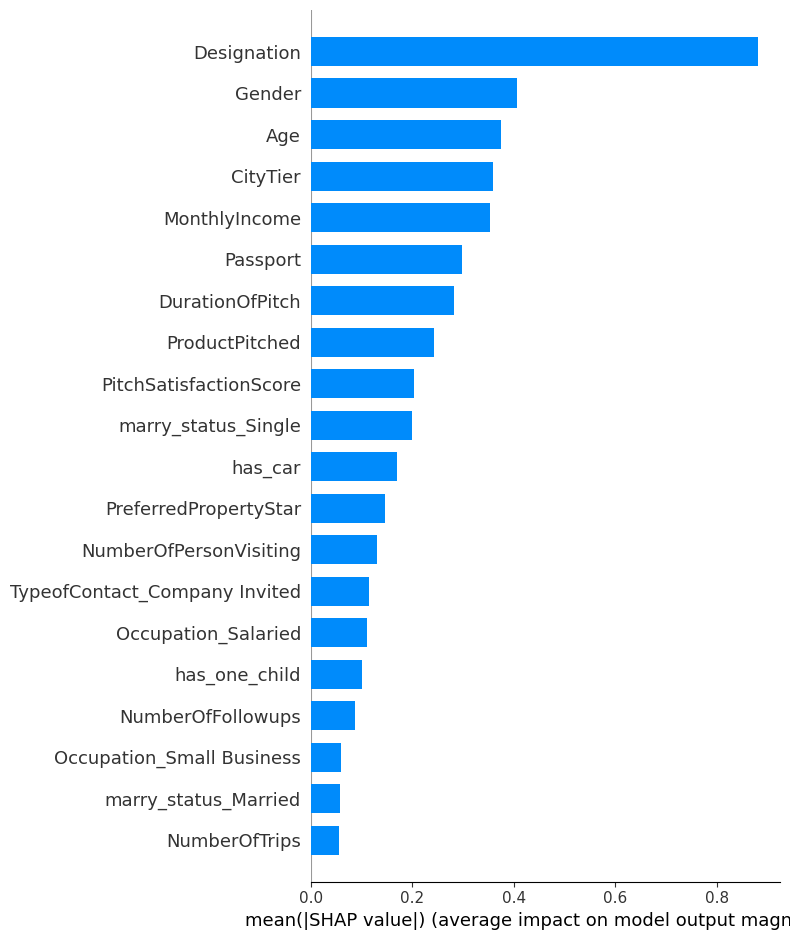

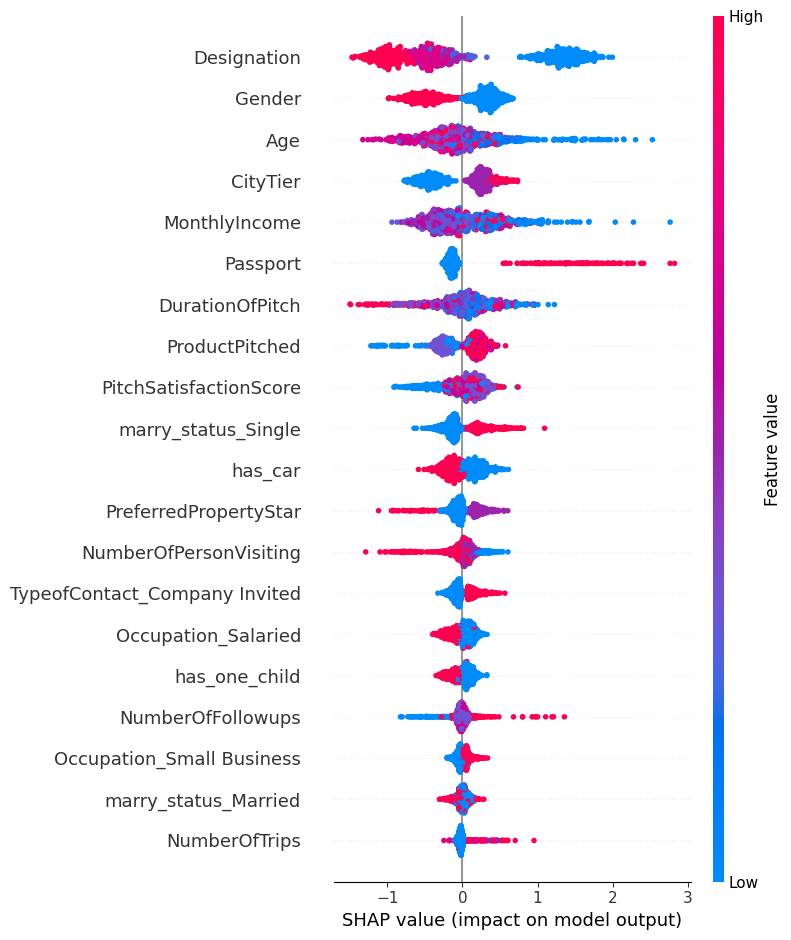

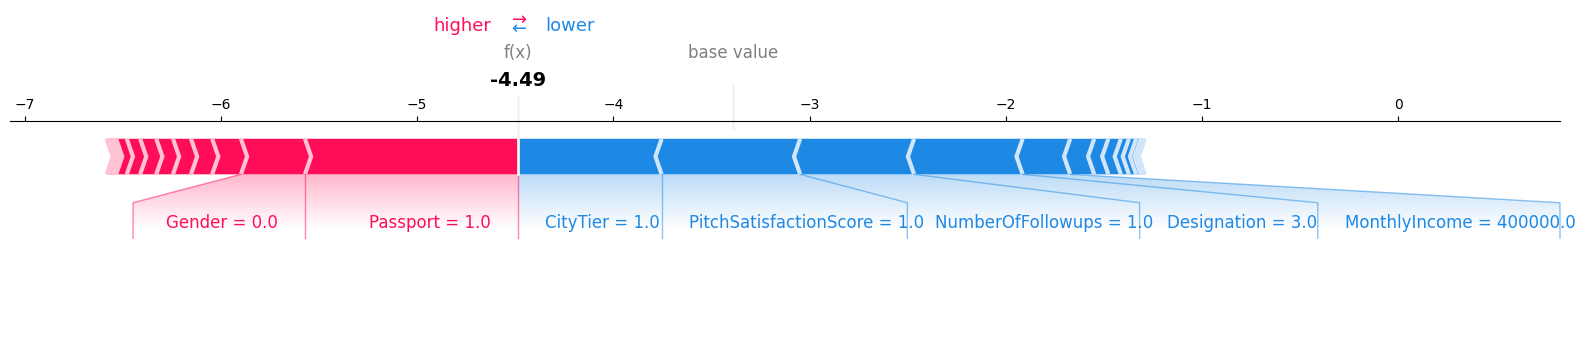

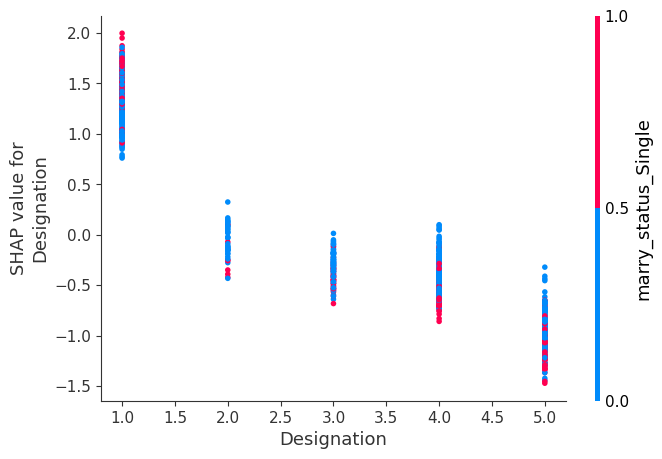

In [ ]:

# SHAPのexplainerを作成
explainer = shap.TreeExplainer(lgb_model)

# 検証データに対するSHAP値を計算
shap_values = explainer.shap_values(X_valid)

# 各特徴量の寄与度を可視化するsummary plot
shap.summary_plot(shap_values, X_valid, plot_type="bar")

# 各特徴量の影響方向を可視化するsummary plot（影響方向込み）
shap.summary_plot(shap_values, X_valid)

# 特定のデータポイントに対するSHAPのforce plotを表示
# ここでは、検証データの最初のサンプルを例にとります
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:], matplotlib=True)

# 特定のデータポイントに対するSHAPのdependence plotを表示
# ここでは、最も重要な特徴量を選んで可視化します
shap.dependence_plot(np.argmax(np.abs(shap_values).mean(0)), shap_values, X_valid)


# 5. 学習と検証


In [ ]:
# ランダムフォレストモデルのインスタンスを作成
rf = RandomForestClassifier(random_state=42)

# パラメータのグリッドを定義
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# グリッドサーチを設定（3分割のクロスバリデーションを使用）
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# トレーニングデータに対してフィッティング
grid_search.fit(X_train, y_train)

# 最適なパラメータを表示
print("Best parameters found: ", grid_search.best_params_)

# 最適なモデルを使ってテストデータを予測
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_valid)

# テストデータに対する精度を表示
print("Test Accuracy: ", accuracy_score(y_valid, y_pred))


AttributeError: 'RandomForestClassifier' object has no attribute 'best_params_'

In [ ]:
# # ランダムフォレストモデルを呼び出します。ランダムフォレストは実行するたびに学習結果が変わることがあるのでrandom_stateに数字を指定して結果を固定します。
# model = RandomForestClassifier(random_state=42)
# # model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
# model.fit(X_train, y_train)

In [ ]:
# predict_proba() で予測します。予測したいデータを入力します。
pred = best_rf.predict_proba(X_valid)

In [ ]:
# 予測の中身を確認します
print(pred[:5])

In [ ]:
y_valid[:5]

In [ ]:
# AUCの評価はroc_auc_score(正解データ, 予測データ)で可能です。
# 成約したかどうかを判定するため、2列目の1の確率(成約している確率)を予測データとして入力します。
score = roc_auc_score(y_valid, pred[:, 1])
print(score)

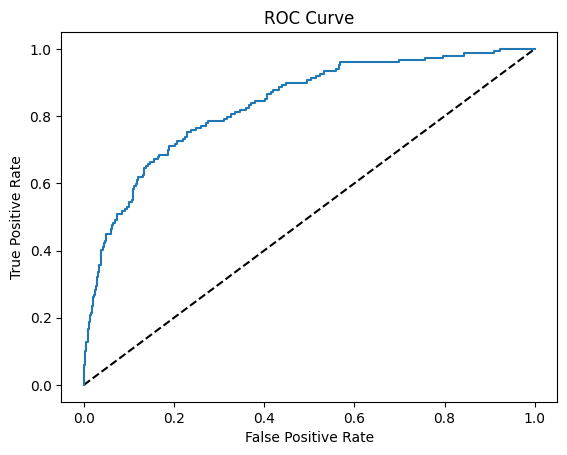

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## 特徴量の重要度を可視化する

Age: 0.13476689729626246
MonthlyIncome: 0.13108689940090412
Designation: 0.08235782455362749
DurationOfPitch: 0.0806525322782791
ProductPitched: 0.07792500186884642
marry_status_Single: 0.06501464421376583
Passport: 0.04161342201604481
PitchSatisfactionScore: 0.03726798898259581
NumberOfFollowups: 0.0343568195130911
CityTier: 0.032273235409765656
NumberOfPersonVisiting: 0.028101755647275926
NumberOfTrips: 0.026331462897803606
PreferredPropertyStar: 0.018672673154750827
has_car: 0.018101413920750688
Gender_M: 0.017516016821210578
marry_status_Married: 0.016594927963426695
Gender_F: 0.016194278495419184
Occupation_Salaried: 0.016136963443893534
Occupation_Large Business: 0.014807065733014813
has_child: 0.014734000492993189
TypeofContact_Self Enquiry: 0.01442791813620436
has_no_child: 0.013219076518294093
TypeofContact_Company Invited: 0.013213115532989555
Occupation_Small Business: 0.012605678270976022
marry_status_Divorced: 0.010871192541229454
has_one_child: 0.010153682492855127
has_tw

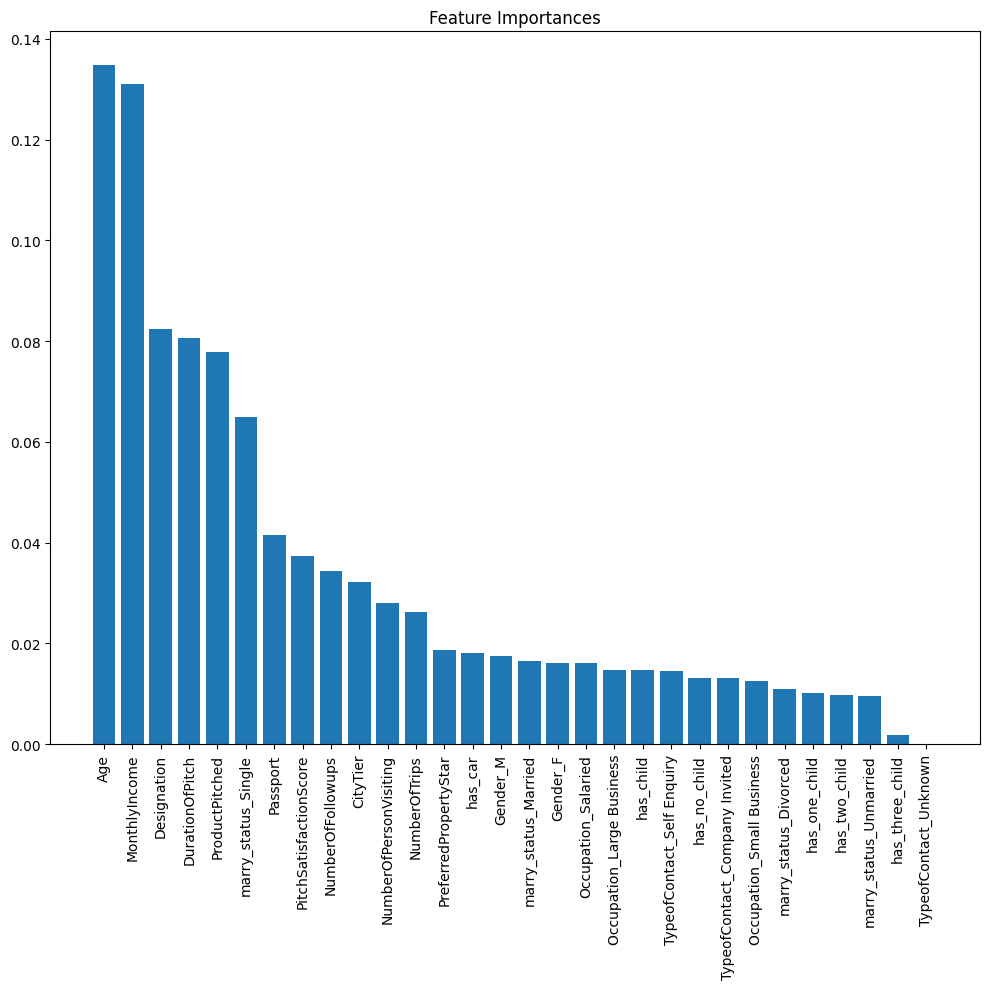

In [ ]:
# 特徴量の重要度を抽出する
importances = best_rf.feature_importances_

# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 重要度の降順で特徴量の名称、重要度を表示
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")

# 表示する
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
print(X_valid.dtypes)

Age                              float64
CityTier                         float64
DurationOfPitch                  float64
NumberOfPersonVisiting           float64
NumberOfFollowups                float64
ProductPitched                   float64
PreferredPropertyStar            float64
NumberOfTrips                    float64
Passport                         float64
PitchSatisfactionScore           float64
Designation                      float64
MonthlyIncome                    float64
has_car                          float64
has_child                        float64
has_no_child                     float64
has_one_child                    float64
has_two_child                    float64
has_three_child                  float64
TypeofContact_Company Invited    float64
TypeofContact_Self Enquiry       float64
TypeofContact_Unknown            float64
Occupation_Large Business        float64
Occupation_Salaried              float64
Occupation_Small Business        float64
Gender_F        

In [ ]:
print(X_valid.dtypes)

Age                              float64
CityTier                         float64
DurationOfPitch                  float64
NumberOfPersonVisiting           float64
NumberOfFollowups                float64
ProductPitched                   float64
PreferredPropertyStar            float64
NumberOfTrips                    float64
Passport                         float64
PitchSatisfactionScore           float64
Designation                      float64
MonthlyIncome                    float64
has_car                          float64
has_child                        float64
has_no_child                     float64
has_one_child                    float64
has_two_child                    float64
has_three_child                  float64
TypeofContact_Company Invited    float64
TypeofContact_Self Enquiry       float64
TypeofContact_Unknown            float64
Occupation_Large Business        float64
Occupation_Salaried              float64
Occupation_Small Business        float64
Gender_F        

In [ ]:
X_valid = X_valid.astype(float)


In [ ]:
# explainerの作成
explainer = shap.TreeExplainer(
      model=best_rf
      ,data=X_valid)

# SHAP値の計算
shap_values = explainer.shap_values(X_valid)

 99%|===================| 2079/2094 [00:46<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.956473, while the model output was 0.966373. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
shap.plots.bar(shap_values=shap_values)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [ ]:
# SHAP summary plot
shap.plots.beeswarm(shap_values, max_display=10)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

## lightGBMモデルの作成

In [ ]:
# LightGBMのインスタンスを作成
lgb_model = lgb.LGBMClassifier(random_state=42)

# パラメータのグリッドを定義
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# グリッドサーチを設定（3分割のクロスバリデーションを使用）
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# トレーニングデータに対してフィッティング
grid_search.fit(X_train, y_train)

# 最適なパラメータを表示
print("Best parameters found: ", grid_search.best_params_)

# 最適なモデルを使ってテストデータを予測
best_lgb = grid_search.best_estimator_
y_pred = best_lgb.predict(X_valid)

# テストデータに対する精度を表示
print("Test Accuracy: ", accuracy_score(y_valid, y_pred))


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


KeyboardInterrupt: 

In [ ]:
# predict_proba() で予測します。予測したいデータを入力します。
pred = best_lgb.predict_proba(X_valid)

In [ ]:
# AUCの評価はroc_auc_score(正解データ, 予測データ)で可能です。
# 成約したかどうかを判定するため、2列目の1の確率(成約している確率)を予測データとして入力します。
score = roc_auc_score(y_valid, pred[:, 1])
print(score)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# 6 提出

In [ ]:
# テストデータを用いて予測します。
predict = best_rf.predict_proba(test)

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/drive/MyDrive/SIGNATE_Cup 2024/data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [ ]:
# 提出ファイルの2列目を予測値で置き換えます。
submit[1] = predict[:, 1]

In [ ]:
#確認してみましょう
submit.head()

,0,1
0,3489,0.051985
1,3490,0.135750
2,3491,0.342451
3,3492,0.345424
4,3493,0.424852


In [ ]:
#submission.csvでデータを保存(提出様式はindex=False, header=Noneとしてください。)
submit.to_csv("submission.csv", index=False, header=None)

In [ ]:
# ディレクトリを指定して保存
file_path = '/content/drive/My Drive/submission.csv'
submit.to_csv(file_path, index=False, header=None)

print(f'File saved to {file_path}')

File saved to /content/drive/My Drive/submission.csv


## 99 EDA

In [ ]:
combined_data.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,MonthlyIncome,ProdTaken,is_train,has_car,has_child,has_no_child,has_one_child,has_two_child,has_three_child,marry_status
0,0,50,Self Enquiry,2,-1,Large Business,M,1.0,4.0,basic,...,253905,1.0,1,0,0,1,0,0,0,Unmarried
1,1,56,Company Invited,1,14,Salaried,M,1.0,4.0,standard,...,404475,0.0,1,1,0,1,0,0,0,Divorced
2,2,-1,Self Enquiry,1,10,Large Business,F,1.0,3.0,basic,...,278145,1.0,1,0,0,1,0,0,0,Married
3,3,37,Self Enquiry,2,-1,Small Business,F,1.0,3.0,standard,...,326805,0.0,1,1,0,1,0,0,0,Divorced
4,4,48,Company Invited,3,-1,Small Business,F,1.0,3.0,basic,...,258435,1.0,1,1,0,1,0,0,0,Single


In [ ]:
combined_data.describe()

,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,is_train,has_car,has_child,has_no_child,has_one_child,has_two_child,has_three_child
count,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,3489.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000
mean,3488.500000,38.192462,1.689882,10.157352,2.401118,3.635426,3.436515,-0.393379,0.098882,2.507022,3.131126,350772.877615,0.142448,0.500000,0.510318,0.715821,0.273574,0.422041,0.229292,0.018487
std,2014.519422,11.822783,0.671595,9.117308,0.734134,0.995513,0.599600,1.617376,0.298525,1.134761,1.675692,87128.713777,0.349559,0.500036,0.499929,0.451055,0.445825,0.493920,0.420408,0.134713
min,0.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,3.000000,-1.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1744.250000,31.000000,1.000000,-1.000000,2.000000,3.000000,3.000000,-1.000000,0.000000,2.000000,1.000000,300000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3488.500000,38.000000,2.000000,10.000000,2.000000,4.000000,3.000000,-1.000000,0.000000,2.000000,4.000000,340312.500000,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5232.750000,46.000000,2.000000,15.000000,3.000000,4.000000,4.000000,-1.000000,0.000000,3.000000,5.000000,400000.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,6977.000000,65.000000,3.000000,36.000000,4.000000,6.000000,5.000000,8.000000,1.000000,5.000000,5.000000,600000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
combined_data_over_0_age = combined_data[combined_data['Age']>=0]
combined_data_over_0_age.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,MonthlyIncome,ProdTaken,is_train,has_car,has_child,has_no_child,has_one_child,has_two_child,has_three_child,marry_status
0,0,50,Self Enquiry,2,-1,Large Business,M,1.0,4.0,basic,...,253905,1.0,1,0,0,1,0,0,0,Unmarried
1,1,56,Company Invited,1,14,Salaried,M,1.0,4.0,standard,...,404475,0.0,1,1,0,1,0,0,0,Divorced
3,3,37,Self Enquiry,2,-1,Small Business,F,1.0,3.0,standard,...,326805,0.0,1,1,0,1,0,0,0,Divorced
4,4,48,Company Invited,3,-1,Small Business,F,1.0,3.0,basic,...,258435,1.0,1,1,0,1,0,0,0,Single
5,5,19,Self Enquiry,2,16,Small Business,M,1.0,3.0,basic,...,260000,0.0,1,0,0,1,0,0,0,Single


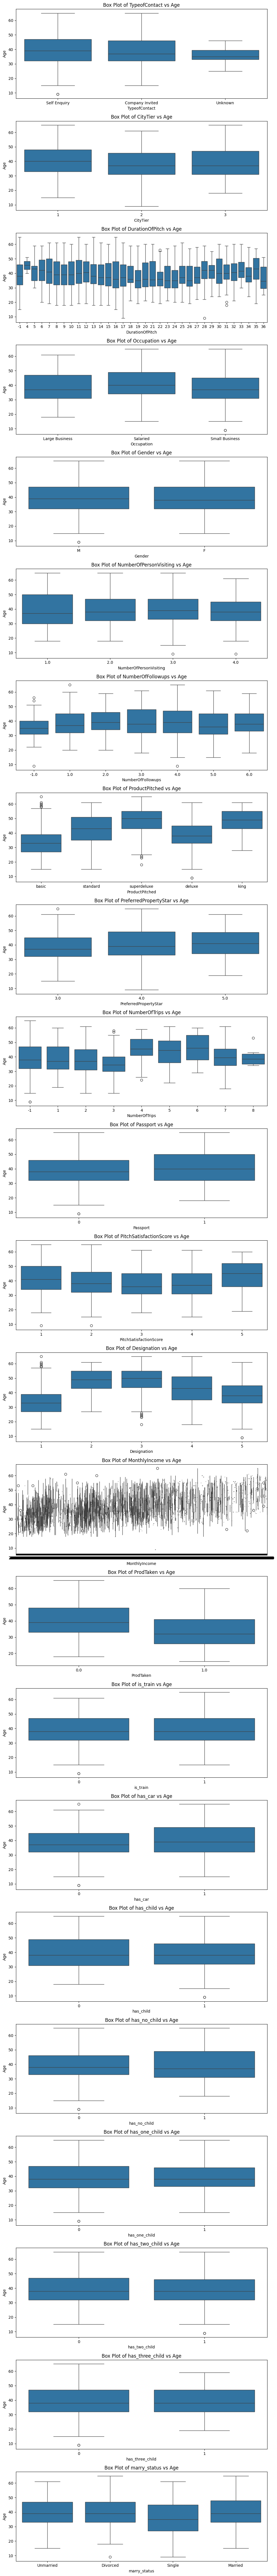

In [ ]:
# 'Age' カラムを y 軸として設定
y = combined_data_over_0_age['Age']

# 各カラムのリスト（'Age', 'id', 'MonthlyIncome' は除外）
columns = [col for col in combined_data_over_0_age.columns if col not in ['Age', 'id']]

# グラフの設定
fig, axes = plt.subplots(len(columns), 1, figsize=(10, len(columns) * 4))

# 各カラムに対して箱ひげ図を描画
for i, col in enumerate(columns):
    ax = axes[i]
    sns.boxplot(x=combined_data_over_0_age[col], y=y, ax=ax)
    ax.set_title(f'Box Plot of {col} vs Age')
    ax.set_xlabel(col)
    ax.set_ylabel('Age')

plt.tight_layout()
plt.show()